In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast

In [3]:
# Load predictions and ground truth
df_gold = pd.read_csv("../dataset/task_a/MTS-Dialog-TestSet-1-MEDIQA-Chat-2023.csv")
df_pred = pd.read_csv("../outputs/taskA_run1.csv")

In [4]:
# Merge on ID
df_merged = df_gold.rename(columns={"ID": "TestID", "section_text": "GoldSectionText"}).merge(
    df_pred[["TestID", "SystemOutput1", "SystemOutput2"]], on="TestID"
)

In [5]:
# Preview
df_merged.head()

,TestID,section_header,GoldSectionText,dialogue,SystemOutput1,SystemOutput2
0,0,GENHX,The patient is a 55-year-old African-American ...,"Doctor: Good afternoon, sir. Did you just have...",PASTMEDICALHX,The patient is a 55-year-old African American ...
1,1,FAM/SOCHX,Positive for stroke and sleep apnea.,Doctor: Any medical issues running in your fam...,FAM/SOCHX,Stroke.
2,2,ROS,"MSK: Negative myalgia, negative joint pain, ne...",Doctor: Any pain in your muscles? \r\nPatient:...,PASTMEDICALHX,No muscle pain. No joint pain. No stiffness or...
3,3,FAM/SOCHX,Noncontributory.,Doctor: Anyone in family with any blood or hea...,FAM/SOCHX,Noncontributory.
4,4,FAM/SOCHX,"Father died of a thoracic aortic aneurysm, age...",Doctor: Can you tell me about your family? Did...,FAM/SOCHX,Father died of thoracic aortic aneurysm. Mom d...


In [7]:
with open("../default_results.json", "r") as f:
    metrics = json.load(f)

print("Global Evaluation Metrics:")
for k, v in metrics["all"].items():
    print(f"{k}: {v:.3f}")

Global Evaluation Metrics:
rouge1: 0.335
rouge2: 0.158
rougeL: 0.284
rougeLsum: 0.284
bertscore_precision: 0.704
bertscore_recall: 0.660
bertscore_f1: 0.675
bleurt: 0.502


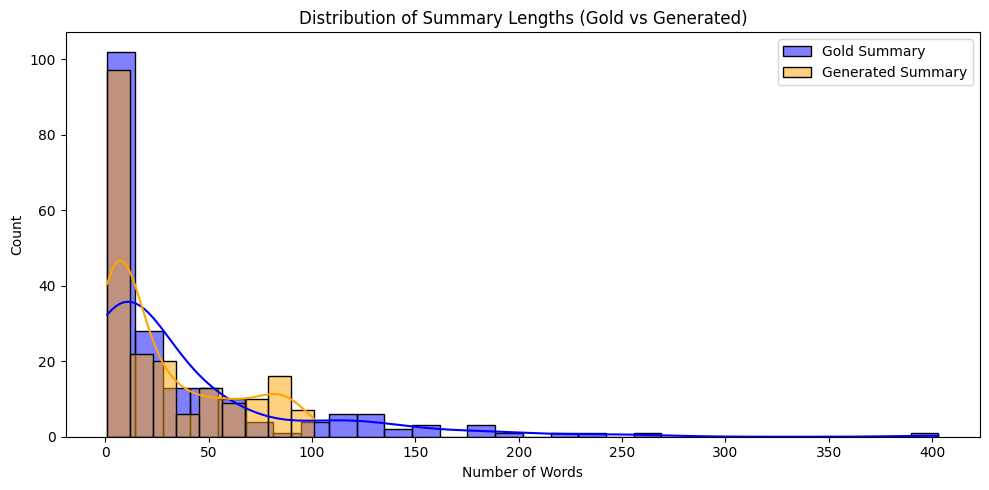

In [8]:
df_merged["GoldLength"] = df_merged["GoldSectionText"].str.split().apply(len)
df_merged["PredLength"] = df_merged["SystemOutput2"].str.split().apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df_merged["GoldLength"], label="Gold Summary", color="blue", kde=True)
sns.histplot(df_merged["PredLength"], label="Generated Summary", color="orange", kde=True)
plt.legend()
plt.title("Distribution of Summary Lengths (Gold vs Generated)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

C:\Users\stoic\AppData\Local\Temp\ipykernel_2368\3599781951.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=section_counts, x="Section", y="Count", palette="crest")


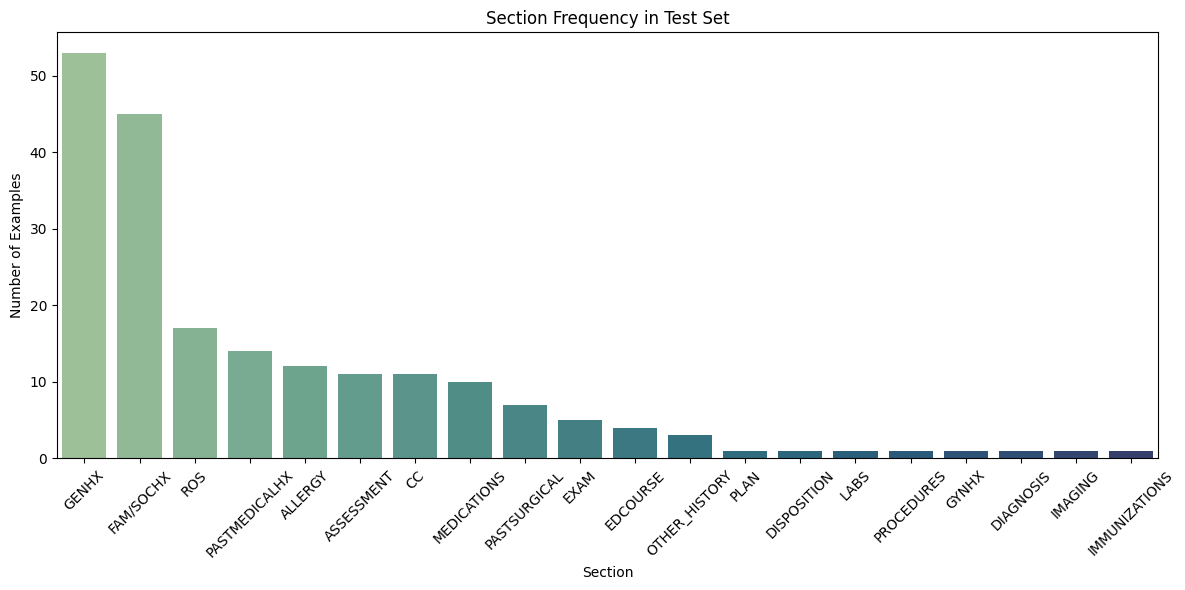

In [9]:
section_counts = df_merged["section_header"].value_counts().reset_index()
section_counts.columns = ["Section", "Count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=section_counts, x="Section", y="Count", palette="crest")
plt.xticks(rotation=45)
plt.title("Section Frequency in Test Set")
plt.ylabel("Number of Examples")
plt.tight_layout()
plt.show()

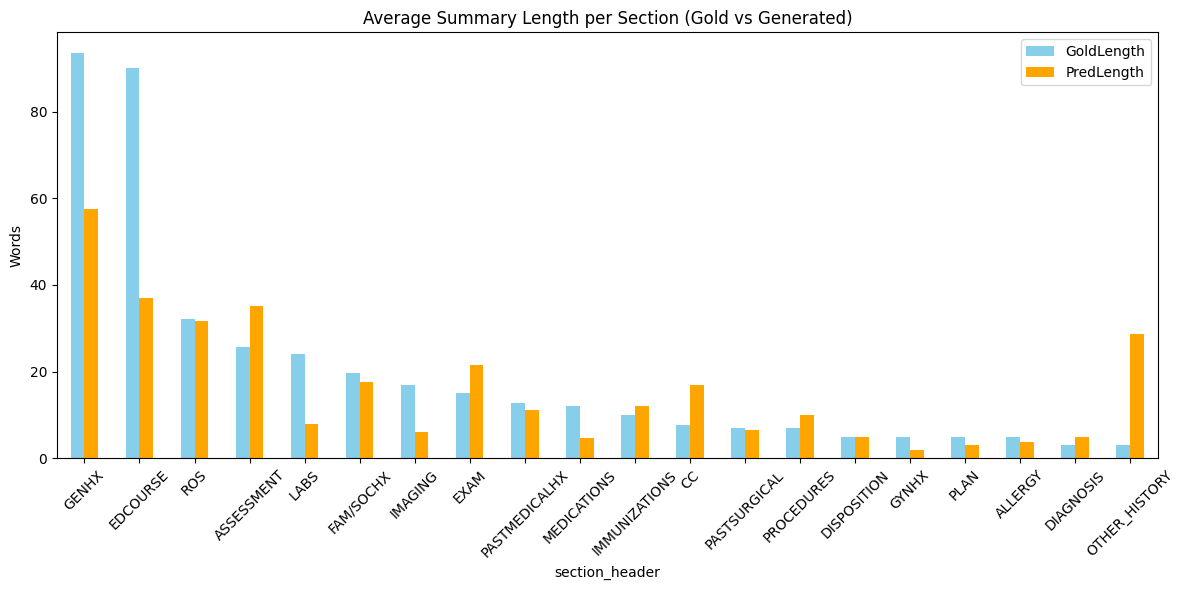

In [10]:
section_stats = df_merged.groupby("section_header")[["GoldLength", "PredLength"]].mean().reset_index()

section_stats = section_stats.sort_values("GoldLength", ascending=False)

section_stats.plot(
    x="section_header",
    y=["GoldLength", "PredLength"],
    kind="bar",
    figsize=(12, 6),
    color=["skyblue", "orange"]
)
plt.xticks(rotation=45)
plt.title("Average Summary Length per Section (Gold vs Generated)")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

In [11]:
for i in [0, 10, 25, 50, 100]:
    row = df_merged.iloc[i]
    print(f"📌 TestID: {row['TestID']} — Section: {row['section_header']}")
    print("🔷 Gold:")
    print(row["GoldSectionText"])
    print("🟠 Generated:")
    print(row["SystemOutput2"])
    print("="*100)

📌 TestID: 0 — Section: GENHX
🔷 Gold:
The patient is a 55-year-old African-American male that was last seen in clinic on 07/29/2008 with diagnosis of new onset seizures and an MRI scan, which demonstrated right contrast-enhancing temporal mass.  Given the characteristics of this mass and his new onset seizures, it is significantly concerning for a high-grade glioma.
🟠 Generated:
The patient is a 55-year-old African American male. He has a birthday. The patient is not bringing his chart with him right now, but the nurse is bringing it.
📌 TestID: 10 — Section: GENHX
🔷 Gold:
The patient is a 79-year-old African-American female with a self reported height of 5 foot 3 inches and weight of 197 pounds.  She was diagnosed with type 2 diabetes in 1983.  She is not allergic to any medicines.
🟠 Generated:
The patient is a 79-year-old African American woman. She is 5'3" tall. She is 187 pounds. She has type 2 diabetes since 1993. She does not have any allergies.
📌 TestID: 25 — Section: FAM/SOCHX
🔷 

In [12]:
df_merged.to_csv("../outputs/taskA_merged_gold_pred.csv", index=False)